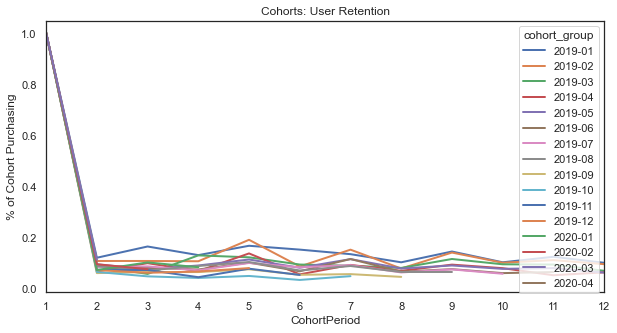

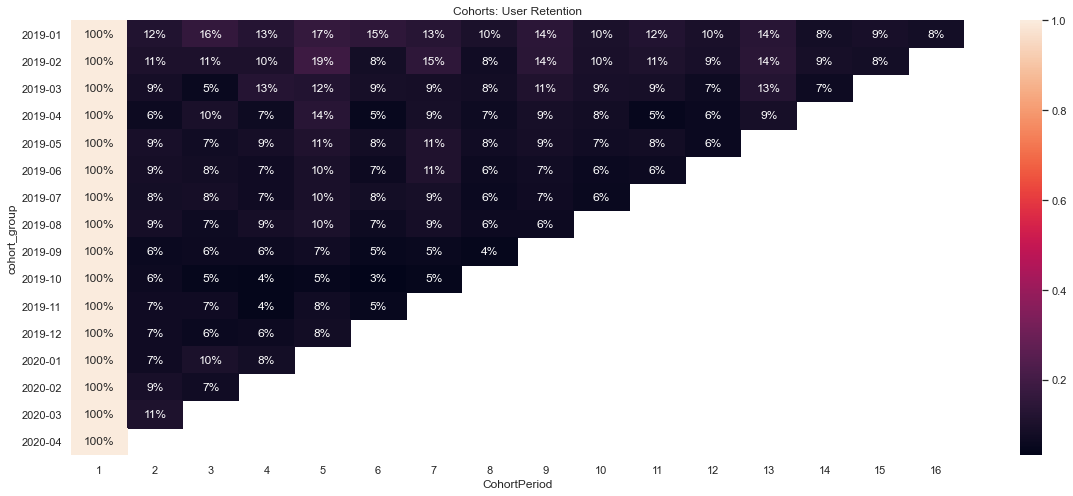

In [471]:
#Learned from http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from datetime import datetime as dt
import seaborn as sns


pd.set_option('display.max_rows', 25)
pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

%matplotlib inline

#import 3 csv's this is how many it took to get the correct number of months worth of data
import_1 = pd.read_csv('orders_export_1 12.csv', dtype={"Location": str, "Payment Method": str, "Cancelled at": str, "Receipt Number": str,"Phone": str})
import_2 = pd.read_csv('orders_export_2 4.csv', dtype={"Location": str, "Payment Method": str, "Cancelled at": str, "Receipt Number": str, "Phone": str})
import_3 = pd.read_csv('orders_export_3.csv', dtype={"Location": str, "Payment Method": str, "Cancelled at": str, "Receipt Number": str, "Phone": str})



#combine CSV's
raw_import = import_1.append(import_2).append(import_3)



#reset index
raw_import = raw_import.reset_index(drop = True)


#because we use email as userId we need to fill in the blank ones with a phone number
raw_import.loc[raw_import['Email'].isnull(),'Email'] = raw_import['Phone']

#filter down to only the needed columns
filtered_import = raw_import.loc[:,[ 'Total','Email', 'Discount Amount', 'Created at', 'Id']]




#Groupby correct columns 
my_list = ['Id','Email','Created at']
my_list_2 = ['Total','Discount Amount']

grouped_filtered = filtered_import.groupby(my_list, as_index = False)[my_list_2].sum() 





#remove all $0 orders
grouped_filtered = grouped_filtered[grouped_filtered.Total != 0]

#reformat numbers to float from scientific notation
pd.options.display.float_format = '{:.0f}'.format

#rename columns to more descriptive terms
grouped_filtered.rename(columns = {'Id':'order_id', 'Email':'user_id',
                              'Created at':'order_date'}, inplace = True)

grouped_filtered['order_date']= pd.to_datetime(grouped_filtered['order_date'])

#create orderPeriod colum from order_date
#grouped_filtered['order_period'] = pd.to_datetime(grouped_filtered['order_date'], format='%m/%d/%y %H:%M')
#grouped_filtered['order_period'] = grouped_filtered['order_period'].dt.strftime('%Y-%m')

grouped_filtered['order_period'] = grouped_filtered.groupby(level=0)['order_date'].min().apply(lambda x: x.strftime('%Y-%m'))
#grouped_filtered.reset_index(inplace=True)



#order_period and order_date to datetime type
grouped_filtered['order_period']= pd.to_datetime(grouped_filtered['order_period'])



#sort by "user_id" column
grouped_filtered = grouped_filtered.sort_values(by=['user_id'])



#create cohort_group Column
grouped_filtered.set_index('user_id', inplace = True)
grouped_filtered['cohort_group'] = grouped_filtered.groupby(level=0)['order_date'].min().apply(lambda x: x.strftime('%Y-%m'))
grouped_filtered.reset_index(inplace=True)








#Rollup data by cohort_group and order_period

grouped = grouped_filtered.groupby(['cohort_group', 'order_period'])


# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'user_id': pd.Series.nunique,
                       'order_id': pd.Series.nunique,
                       'Total': np.sum,
                       'Discount Amount': np.sum})

#rename columns to make more sense
cohorts.rename(columns={'user_id': 'Total Users',
                        'order_id': 'Total Orders'}, inplace = True)


#create a function that appends cohort_period to df

def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

#run function on cohorts df
cohorts = cohorts.groupby(level = 0).apply(cohort_period)



####################################################################################################

#testing to make sure transformations worked correctly
x = grouped_filtered[(grouped_filtered.cohort_group == '2019-01') & (grouped_filtered.order_period == '2019-01-01')]
y = cohorts.loc[('2019-01', '2019-01-01')]

assert(x['user_id'].nunique() == y['Total Users'])
assert(x['Total'].sum().round(2) == y['Total'].round(2))
assert(x['order_id'].nunique() == y['Total Orders'])

x = grouped_filtered[(grouped_filtered.cohort_group == '2019-01') & (grouped_filtered.order_period == '2019-09')]
y = cohorts.loc[('2019-01', '2019-09-01')]

assert(x['user_id'].nunique() == y['Total Users'])
assert(x['Total'].sum().round(2) == y['Total'].round(2))
assert(x['order_id'].nunique() == y['Total Orders'])

x = grouped_filtered[(grouped_filtered.cohort_group == '2019-05') & (grouped_filtered.order_period == '2019-09-01')]
y = cohorts.loc[('2019-05', '2019-09-01')]

assert(x['user_id'].nunique() == y['Total Users'])
assert(x['Total'].sum().round(2) == y['Total'].round(2))
assert(x['order_id'].nunique() == y['Total Orders'])

####################################################################################################

# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_group', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['Total Users'].groupby(level=0).first()
#cohort_group_size.head() 




user_retention = cohorts['Total Users'].unstack(0).divide(cohort_group_size, axis=1)
pd.options.display.float_format = '{:,.2f}'.format




user_retention.loc[:].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');



sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');



